<class 'networkx.classes.multidigraph.MultiDiGraph'>


c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Linus\AppData\Local\Temp\ipykernel_18824\3708619141.py:91: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-fr

[[66861087, 262594280, 335539182], [335539182, 34095673, 218289611, 34095662, 216510485, 335482039, 35830593, 218307467], [218307467, 216508839, 218304990], [218304990, 2303493391, 28106266, 2504875221, 2504875390, 2349162325, 2349162339, 2349162328, 34095620, 227531247, 227531502], [227531502, 227531247, 34095620, 463218029, 28105688], [28105688, 28105552, 463218498, 413002526, 28105334, 240268801, 463218829, 28105093, 28104872, 28104877, 28104861, 10307592895], [10307592895, 28104861, 28104877, 28104872, 120393579], [120393579, 225061965, 216297840, 274103688, 469835796, 120393573], [120393573, 7555510252, 120393570, 216292600, 1493171026, 264890212, 1509996838, 264890214, 216282009, 4083586928, 216282586, 216283486, 393962506], [393962506, 216283486, 216282586, 4083586928, 4083586933, 469833806, 469833850, 1880125007], [1880125007, 291902375, 291902959, 291902370, 35831193, 2459192571, 1599382891, 233039815, 265155506, 27505281, 27505280, 35831539], [35831539, 27505267, 1479539363, 

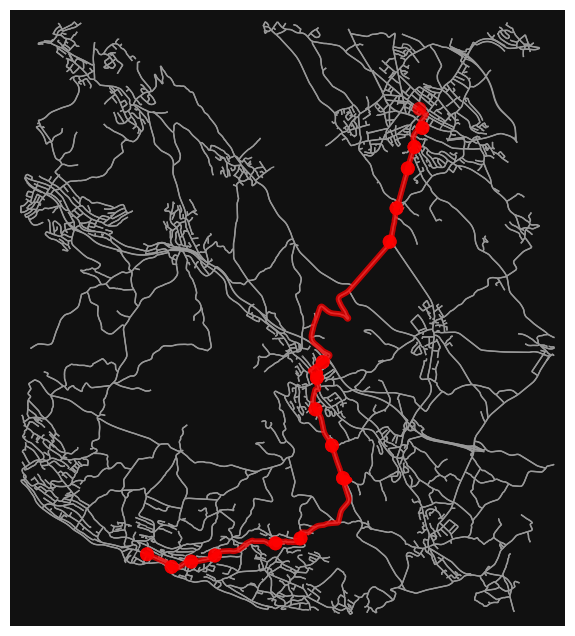

Gesamtlänge der Route: 33.827629 Kilometer


In [1]:
import pyproj
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import nearest_points
from shapely.geometry import Point
import osmnx as ox
import json
import os

ROOT_FILES = 'C:/Users/Linus/PycharmProjects/BA/'
ROOT_Busstations = 'src/main/resources/Buslinie/Busstationen/'

#Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'

# Minimale und maximale Breite und Länge des Rechtecks
north, south, east, west = 47.3667, 47.2586, 8.754, 8.6103

# Herunterladen des Straßennetzwerks basierend auf dem Rechteck
G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

# Konvertieren des Graphen in ein GeoJSON-FeatureCollection
features = ox.graph_to_gdfs(G, nodes=False, edges=True)
geojson_data = features.to_json()

# Bestimmen des relativen Pfads
file_path = ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + "strassenetzwerk.geojson"

# Schreiben des GeoJSON-Daten in die Datei
with open(file_path, "w") as f:
    json.dump(geojson_data, f)

# impute edge (driving) speeds and calculate edge travel times
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from GeoPandas GeoDataFrames
print(type(G))
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
G = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.utils_graph.get_digraph(G, weight="travel_time")

#Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'
#DATEN_STRASSENNETZ = gpd.read_file(ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + 'Tramstrasse.shp')

# save graph as a geopackage or graphml file
ox.io.save_graph_geopackage(G, filepath = ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + "./OSMStrassennetz.gpkg")

# Pfad zur Shapefile-Datei mit den Bushaltestellen
shapefile_path = ROOT_FILES + ROOT_Busstations + "Bushalte.shp"

# Laden der Bushaltestellen als GeoDataFrame
bus_stops = gpd.read_file(shapefile_path)

def add_return_trip(bus_stops):
    # Kopiere das GeoDataFrame, um die Rückfahrt-Haltestellen hinzuzufügen
    return_trip_stops = bus_stops.copy()

    # Entferne die Haltestelle mit der niedrigsten und höchsten ID
    return_trip_stops = return_trip_stops.iloc[:-1]

    # Kehre die Reihenfolge der Haltestellen um
    return_trip_stops = return_trip_stops.iloc[::-1]

    # Füge die Rückfahrt-Haltestellen hinzu
    bus_stops_with_return = pd.concat([bus_stops, return_trip_stops], ignore_index=True)
    
    return bus_stops_with_return

# Beispielaufruf
bus_stops_with_return = add_return_trip(bus_stops)

# LV95 Projektionsdefinition
lv95 = pyproj.Proj(init='epsg:2056')

# WGS 84 Projektionsdefinition
wgs84 = pyproj.Proj(init='epsg:4326')

bus_stops_with_return_wgs84 = bus_stops_with_return.copy()

# Funktion zur Umwandlung von LV95 nach WGS 84
def lv95_to_wgs84(point):
    x_lv95, y_lv95 = point.x, point.y
    x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
    return Point(x_wgs84, y_wgs84)

# Beispiel GeoDataFrame
# Annahme: MeinGDF ist Ihr GeoDataFrame
# Annahme: Die Geometrie ist vom Typ Point
bus_stops_with_return_wgs84['geometry'] = bus_stops_with_return_wgs84['geometry'].apply(lv95_to_wgs84)

# Annahme: G ist Ihr Graph mit dem Straßennetzwerk
# Annahme: points_gdf ist Ihr GeoDataFrame mit den Punkten

# Definieren Sie eine Funktion, um die nächsten Netzwerkknoten zu einem Punkt zu finden
def get_nearest_node(G, point):
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    return nearest_node

# Lesen Sie das GeoDataFrame ein
points_gdf = bus_stops_with_return_wgs84

# Erstellen Sie eine leere Liste, um die Routen zu speichern
routes = []
# Erstellen Sie eine leere Liste, um die Längen der Routen zu speichern
route_lengths = []

# Iterieren Sie durch das GeoDataFrame und finden Sie für jeden Punkt den kürzesten Pfad
for idx, row in points_gdf.iterrows():
    orig = get_nearest_node(G, row['geometry'])
    # Hier suchen wir den nächsten Punkt zum aktuellen Punkt
    next_row = points_gdf.iloc[(idx + 1) % len(points_gdf)]
    dest = get_nearest_node(G, next_row['geometry'])
    route = ox.shortest_path(G, orig, dest, weight="length")
    routes.append(route)
    # Berechnen Sie die Länge des Pfades und fügen Sie sie der Liste hinzu
    route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
    route_lengths.append(route_length)

print(routes)
# Plotten Sie alle Routen
fig, ax = ox.plot_graph_routes(G, routes, node_size=0)

# Summieren Sie die Längen der Routen, um die Gesamtlänge zu erhalten
total_route_length = sum(route_lengths) / 1000
print("Gesamtlänge der Route:", total_route_length, "Kilometer")

In [16]:
import pandas as pd

def compute_shortest_paths_with_time(G, points_gdf, timestamp, average_speed):
    routes = []
    route_lengths = []
    arrival_times = []

    prev_stop = points_gdf.iloc[-1]  # Der letzte Punkt wird als Startpunkt für die Berechnung der Reisezeit verwendet
    half_way = len(points_gdf) // 2  # Bestimme die Position der Hälfte der Haltestellen
    
    for idx, row in enumerate(points_gdf.iterrows()):
        orig = get_nearest_node(G, prev_stop['geometry'])
        dest = get_nearest_node(G, row[1]['geometry'])
        route = ox.shortest_path(G, orig, dest, weight="length")
        routes.append(route)
        
        route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
        route_lengths.append(route_length)
        
        # Berechne die Reisezeit zwischen den Haltestellen
        travel_time = route_length / average_speed
        
        # Füge eine Pause von 5 Minuten in der Mitte der Route ein
        if idx == half_way:
            travel_time += 5
        
        # Berechne die Ankunftszeit an der Haltestelle
        arrival_time = timestamp + pd.Timedelta(minutes=travel_time)
        arrival_times.append(arrival_time)
        
        # Aktualisiere den vorherigen Punkt für die nächste Iteration
        prev_stop = row[1]
        timestamp = arrival_time  # Aktualisiere den Timestamp für die nächste Haltestelle
    
    # Füge die Ankunftszeiten dem points_gdf hinzu
    points_gdf_with_time = points_gdf.copy()
    points_gdf_with_time['arrival_time'] = arrival_times
    
    return routes, route_lengths, points_gdf_with_time

# Beispielaufruf der Funktion
timestamp = pd.Timestamp("2018-04-20 09:00:00")
average_speed = 666  # Annahme: Durchschnittsgeschwindigkeit von 40 km/h
routes, route_lengths, points_gdf_with_time = compute_shortest_paths_with_time(G, bus_stops_with_return_wgs84, timestamp, average_speed)

print(points_gdf_with_time)


C:\Users\Linus\AppData\Local\Temp\ipykernel_18824\762762235.py:17: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
C:\Users\Linus\AppData\Local\Temp\ipykernel_18824\762762235.py:17: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
C:\Users\Linus\AppData\Local\Temp\ipykernel_18824\762762235.py:17: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
C:\Users\Linus\AppData\Local\Temp\ipykernel_18824\762762235.py:17: UserWarning: Th

    id                         name              geometry  \
0    1              Meilen, Bahnhof  POINT (8.644 47.269)   
1    2               Meilen, Beugen  POINT (8.651 47.267)   
2    3            Meilen, Schulhaus  POINT (8.657 47.268)   
3    4             Meilen, Aebleten  POINT (8.663 47.269)   
4    5     Uetikon am See, Rundiweg  POINT (8.678 47.272)   
5    6     Uetikon am See, Bergheim  POINT (8.686 47.272)   
6    7         Egg, Ausser-Vollikon  POINT (8.697 47.283)   
7    8          Egg, Inner-Vollikon  POINT (8.694 47.289)   
8    9             Egg, Rainstrasse  POINT (8.690 47.296)   
9   10               Egg, Forchbahn  POINT (8.690 47.301)   
10  11               Egg, Industrie  POINT (8.692 47.305)   
11  12  Riedikon, Chis/Naturstation  POINT (8.710 47.326)   
12  13               Riedikon, Dorf  POINT (8.711 47.332)   
13  14             Uster, Im Hölzli  POINT (8.714 47.339)   
14  15              Uster, Talacker  POINT (8.716 47.343)   
15  16        Uster, Zen

C:\Users\Linus\AppData\Local\Temp\ipykernel_18824\762762235.py:17: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))


In [17]:
print(bus_stops_with_return)

    id                         name                         geometry
0    1              Meilen, Bahnhof  POINT (2691216.442 1236097.130)
1    2               Meilen, Beugen  POINT (2691721.577 1235859.957)
2    3            Meilen, Schulhaus  POINT (2692164.131 1235952.189)
3    4             Meilen, Aebleten  POINT (2692625.713 1236089.963)
4    5     Uetikon am See, Rundiweg  POINT (2693795.522 1236390.838)
5    6     Uetikon am See, Bergheim  POINT (2694359.533 1236444.631)
6    7         Egg, Ausser-Vollikon  POINT (2695191.913 1237693.175)
7    8          Egg, Inner-Vollikon  POINT (2694957.869 1238374.380)
8    9             Egg, Rainstrasse  POINT (2694619.737 1239083.099)
9   10               Egg, Forchbahn  POINT (2694600.924 1239702.345)
10  11               Egg, Industrie  POINT (2694763.351 1240053.164)
11  12  Riedikon, Chis/Naturstation  POINT (2696074.245 1242503.350)
12  13               Riedikon, Dorf  POINT (2696196.601 1243162.888)
13  14             Uster, Im Hölzl

In [23]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from collections import Counter
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Point
import geopandas as gpd
import json

def load_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Beispielaufruf der Funktion
ROOT_DOCS = 'src/main/resources/Dokumente/'
file_path = ROOT_FILES + ROOT_DOCS + "Nachfrage.geojson"
demand_geojson = load_geojson(file_path)
file_path = ROOT_FILES + ROOT_DOCS + "Ziele.geojson"
destination_geojson = load_geojson(file_path)
print(demand_geojson)
print(type(demand_geojson))

import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

def passengers_on_bus(bus_stops_gdf, demand_geojson, destination_geojson):
    passengers = []

    # Extrahiere Busstop-Koordinaten und Ankunftszeit des Busses
    bus_stop_coords = [(point.x, point.y) for point in bus_stops_gdf.geometry]
    bus_arrival_timestamp = bus_stops_gdf['arrival_time'].iloc[0]  # Annahme: Der Bus hält nur einmal, daher wird die Ankunftszeit des ersten Haltestellenpunkts verwendet

    # Extrahiere Nachfrage-Koordinaten und Ziele für jeden Passagier
    for demand_feature, dest_feature in zip(demand_geojson['features'], destination_geojson['features']):
        passenger_origin = Point(demand_feature['geometry']['coordinates'])
        passenger_destination = Point(dest_feature['geometry']['coordinates'])

        # Überprüfe, ob sowohl der Start- als auch der Zielpunkt innerhalb des Busbereichs liegen
        origin_in_buffer = False
        destination_in_buffer = False
        for coord in bus_stop_coords:
            bus_stop_point = Point(coord)
            if bus_stop_point.buffer(500).contains(passenger_origin):
                origin_in_buffer = True
            if bus_stop_point.buffer(500).contains(passenger_destination):
                destination_in_buffer = True
            if origin_in_buffer and destination_in_buffer:
                # Überprüfe, ob der Timestamp der Nachfrage innerhalb von 15 Minuten nach der Ankunft des Busses liegt
                demand_timestamp = pd.Timestamp(demand_feature['properties']['timestamp'])
                bus_arrival_time = bus_arrival_timestamp + pd.Timedelta(minutes=15)
                if demand_timestamp <= bus_arrival_time:
                    passengers.append({
                        'origin': passenger_origin,
                        'destination': passenger_destination,
                        'timestamp': demand_timestamp
                    })
                break  # Sobald ein Bus gefunden wurde, brechen wir die Schleife ab

    # Erstelle ein GeoDataFrame aus den Passagieren
    passenger_points = [passenger['origin'] for passenger in passengers]
    passengers_gdf = gpd.GeoDataFrame(passengers, geometry=passenger_points)
    
    return passengers_gdf




passengers_gdf = passengers_on_bus(points_gdf_with_time, demand_geojson, destination_geojson)
print(passengers_gdf)


{'type': 'FeatureCollection', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::2056'}}, 'features': [{'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:55:02', 'gemeinde': 'Egg', 'passagier_nummer': 1}, 'geometry': {'type': 'Point', 'coordinates': [2694609.751670501, 1239613.9681586307]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:14:17', 'gemeinde': 'Egg', 'passagier_nummer': 2}, 'geometry': {'type': 'Point', 'coordinates': [2694148.5703675556, 1240346.7810548947]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:53:02', 'gemeinde': 'Egg', 'passagier_nummer': 3}, 'geometry': {'type': 'Point', 'coordinates': [2694148.5703675556, 1240346.7810548947]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:40:18', 'gemeinde': 'Egg', 'passagier_nummer': 4}, 'geometry': {'type': 'Point', 'coordinates': [2695214.397591918, 1237702.6080530724]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:10:04

In [25]:
def passengers_on_bus(bus_stops_gdf, demand_geojson, destination_geojson):
    passengers = []

    # Extrahiere Busstop-Koordinaten
    bus_stop_coords = [(point.x, point.y) for point in bus_stops_gdf.geometry]

    # Extrahiere Nachfrage-Koordinaten und Ziele für jeden Passagier
    for demand_feature, dest_feature in zip(demand_geojson['features'], destination_geojson['features']):
        passenger_origin = Point(demand_feature['geometry']['coordinates'])
        passenger_destination = Point(dest_feature['geometry']['coordinates'])

        # Überprüfe, ob sowohl der Start- als auch der Zielpunkt innerhalb des Busbereichs liegen
        origin_in_buffer = False
        destination_in_buffer = False
        for coord in bus_stop_coords:
            bus_stop_point = Point(coord)
            if bus_stop_point.buffer(500).contains(passenger_origin):
                origin_in_buffer = True
            if bus_stop_point.buffer(500).contains(passenger_destination):
                destination_in_buffer = True
            if origin_in_buffer and destination_in_buffer:
                passengers.append({
                    'origin': passenger_origin,
                    'destination': passenger_destination,
                    'timestamp': demand_feature['properties']['timestamp']
                })
                break  # Sobald ein Bus gefunden wurde, brechen wir die Schleife ab

    # Erstelle ein GeoDataFrame aus den Passagieren
    passengers_gdf = gpd.GeoDataFrame(passengers, geometry='origin')
    
    return passengers_gdf

# Beispielaufruf der Funktion
passengers_on_bus(bus_stops_with_return, demand_geojson, destination_geojson)
passengers_gdf = passengers_on_bus(bus_stops_with_return, demand_geojson, destination_geojson)
print(passengers_gdf)

                            origin  \
0  POINT (2695214.398 1237702.608)   
1  POINT (2694581.800 1239041.297)   
2  POINT (2694176.075 1239605.874)   
3  POINT (2696357.723 1244739.362)   
4  POINT (2696965.808 1244220.615)   

                                     destination            timestamp  
0   POINT (2690794.690388481 1236160.4874132331)  2018-04-20T09:40:18  
1  POINT (2696452.9522747234 1244895.1179973318)  2018-04-20T09:05:16  
2   POINT (2696836.2570331525 1244724.096414338)  2018-04-20T09:55:03  
3   POINT (2694929.450672205 1239984.8066820996)  2018-04-20T09:16:01  
4    POINT (2694835.385607417 1240028.798958106)  2018-04-20T09:51:30  


{'type': 'FeatureCollection', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::2056'}}, 'features': [{'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:55:02', 'gemeinde': 'Egg', 'passagier_nummer': 1}, 'geometry': {'type': 'Point', 'coordinates': [2694609.751670501, 1239613.9681586307]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:14:17', 'gemeinde': 'Egg', 'passagier_nummer': 2}, 'geometry': {'type': 'Point', 'coordinates': [2694148.5703675556, 1240346.7810548947]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:53:02', 'gemeinde': 'Egg', 'passagier_nummer': 3}, 'geometry': {'type': 'Point', 'coordinates': [2694148.5703675556, 1240346.7810548947]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:40:18', 'gemeinde': 'Egg', 'passagier_nummer': 4}, 'geometry': {'type': 'Point', 'coordinates': [2695214.397591918, 1237702.6080530724]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T09:10:04

C:\Users\Linus\AppData\Local\Temp\ipykernel_18824\1467240333.py:77: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  destination_gdf['geometry'] = passengers_gdf['destination'].apply(Point)


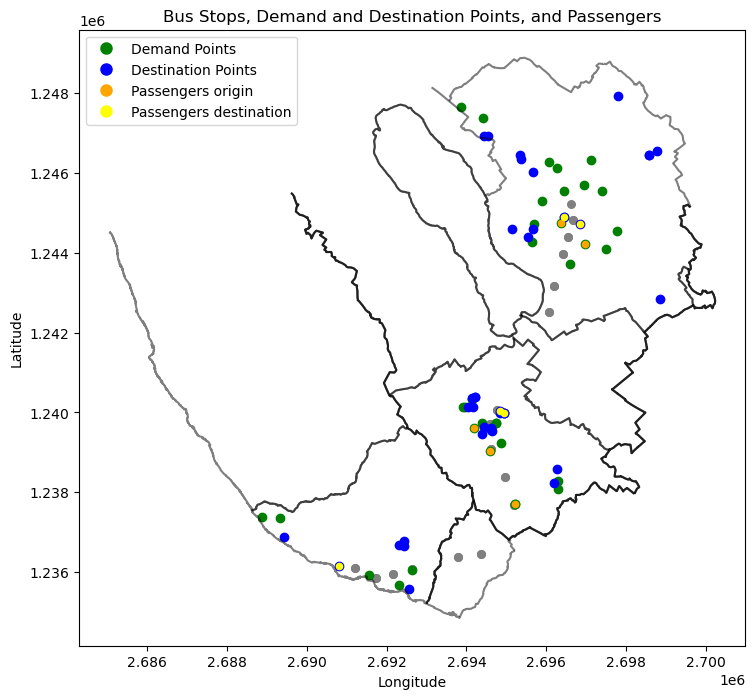

Anzahl der Passagiere im Bus: 5


In [2]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from collections import Counter
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Point
import geopandas as gpd
import json

def load_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Beispielaufruf der Funktion
ROOT_DOCS = 'src/main/resources/Dokumente/'
file_path = ROOT_FILES + ROOT_DOCS + "Nachfrage.geojson"
demand_geojson = load_geojson(file_path)
file_path = ROOT_FILES + ROOT_DOCS + "Ziele.geojson"
destination_geojson = load_geojson(file_path)
print(demand_geojson)
print(type(demand_geojson))

def passengers_on_bus(bus_stops_gdf, demand_geojson, destination_geojson):
    passengers = []

    # Extrahiere Busstop-Koordinaten
    bus_stop_coords = [(point.x, point.y) for point in bus_stops_gdf.geometry]

    # Extrahiere Nachfrage-Koordinaten und Ziele für jeden Passagier
    for demand_feature, dest_feature in zip(demand_geojson['features'], destination_geojson['features']):
        passenger_origin = Point(demand_feature['geometry']['coordinates'])
        passenger_destination = Point(dest_feature['geometry']['coordinates'])

        # Überprüfe, ob sowohl der Start- als auch der Zielpunkt innerhalb des Busbereichs liegen
        origin_in_buffer = False
        destination_in_buffer = False
        for coord in bus_stop_coords:
            bus_stop_point = Point(coord)
            if bus_stop_point.buffer(500).contains(passenger_origin):
                origin_in_buffer = True
            if bus_stop_point.buffer(500).contains(passenger_destination):
                destination_in_buffer = True
            if origin_in_buffer and destination_in_buffer:
                passengers.append({
                    'origin': passenger_origin,
                    'destination': passenger_destination,
                    'timestamp': demand_feature['properties']['timestamp']
                })
                break  # Sobald ein Bus gefunden wurde, brechen wir die Schleife ab

    # Erstelle ein GeoDataFrame aus den Passagieren
    passengers_gdf = gpd.GeoDataFrame(passengers, geometry='origin')
    
    return passengers_gdf

# Beispielaufruf der Funktion
passengers_on_bus(bus_stops_with_return, demand_geojson, destination_geojson)
passengers_gdf = passengers_on_bus(bus_stops_with_return, demand_geojson, destination_geojson)

import matplotlib.pyplot as plt
import osmnx as ox
from shapely.geometry import Point

# Lade und plotte die Shapefile
shp_file = ROOT_FILES + 'src/main/resources/QGIS/Gemeindegrenzen/Grenzen_komp.shp'
gemeindegrenzen = gpd.read_file(shp_file)

def plot_passengers(passengers_gdf, bus_stops_gdf, demand_geojson, destination_geojson, gemeindegrenzen):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Erstelle GeoDataFrames für origin und destination
    origin_gdf = passengers_gdf[['origin', 'timestamp']].copy()
    destination_gdf = gpd.GeoDataFrame()

    destination_gdf['destination'] = None
    destination_gdf['geometry'] = passengers_gdf['destination'].apply(Point)
    destination_gdf = gpd.GeoDataFrame(destination_gdf)
    destination_gdf.set_geometry('geometry', inplace=True)

    # Plotte Busstop
    bus_stops_gdf.plot(ax=ax, color='grey', markersize=30, label='Bus Stops')
    #print(bus_stops_gdf)

    # Plotte Nachfragepunkte
    for feature in demand_geojson['features']:
        point = Point(feature['geometry']['coordinates'])
        ax.plot(point.x, point.y, 'go', markersize=6)

    # Plotte Zielpunkte
    for feature in destination_geojson['features']:
        point = Point(feature['geometry']['coordinates'])
        ax.plot(point.x, point.y, 'bo', markersize=6)

    # Plotte Passagiere
    origin_gdf.plot(ax=ax, color='orange', markersize=20, label='Origin Points', zorder=2)
    destination_gdf.plot(ax=ax, color='yellow', markersize=20, label='Destination Points', zorder=2)

    # Plotte Gemeindegrenzen
    gemeindegrenzen.plot(ax=ax, color='black', alpha=0.5, label='Shapefile')

    ax.set_title('Bus Stops, Demand and Destination Points, and Passengers')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Erstelle die Legende manuell
    demand_legend = plt.Line2D([], [], color='green', marker='o', markersize=8, linestyle='None', label='Demand Points')
    destination_legend = plt.Line2D([], [], color='blue', marker='o', markersize=8, linestyle='None', label='Destination Points')
    passengers_demand_legend = plt.Line2D([], [], color='orange', marker='o', markersize=8, linestyle='None', label='Passengers origin')
    passengers_destination_legend = plt.Line2D([], [], color='yellow', marker='o', markersize=8, linestyle='None', label='Passengers destination')

    ax.legend(handles=[demand_legend, destination_legend, passengers_demand_legend, passengers_destination_legend], loc='upper left')

    plt.show()

# Beispielaufruf der Funktion
plot_passengers(passengers_gdf, bus_stops_with_return, demand_geojson, destination_geojson, gemeindegrenzen)

# Anzahl der Zeilen im GeoJSON berechnen
num_passagiere = passengers_gdf.shape[0]

# Anzahl der Zeilen ausgeben
print("Anzahl der Passagiere im Bus:", num_passagiere)


                            origin  \
0  POINT (2694625.247 1239548.530)   
1  POINT (2694445.847 1239636.790)   
2  POINT (2694860.898 1239245.775)   
3  POINT (2696740.952 1244961.505)   
4  POINT (2696434.153 1245546.169)   
5  POINT (2696584.114 1243002.214)   
6  POINT (2696965.808 1244220.615)   

                                     destination            timestamp  
0  POINT (2696434.1525430055 1245546.1690472097)  2018-04-20T19:32:04  
1    POINT (2692241.351027946 1235624.143852777)  2018-04-20T12:38:49  
2   POINT (2696720.1704185577 1245121.090931574)  2018-04-21T06:34:59  
3   POINT (2694812.743026448 1239916.3582374786)  2018-04-21T06:07:47  
4    POINT (2694835.385607417 1240028.798958106)  2018-04-21T00:10:06  
5   POINT (2694812.743026448 1239916.3582374786)  2018-04-20T12:27:41  
6    POINT (2694625.247034027 1239548.529510025)  2018-04-20T17:03:26  


In [ ]:
def process_demand_points(demand_gdf, target_gdf, main_stops_gdf, graph):    
    # Initialisiere Zähler für erfolgreiche Fahrten
    successful_trips = 0
    
    # Iteriere durch jeden Nachfragepunkt
    for idx, demand_point in demand_gdf.iterrows():
        # Finde den nächsten Punkt im Straßennetzwerk
        nearest_point = find_nearest_point(graph, demand_point.geometry)
        print('Nächster Punkt', nearest_point)
        
        # Berechne die Zeit bis zum nächsten Punkt
        travel_time_to_nearest = calculate_travel_time(graph, demand_point.geometry, nearest_point)
        print('Zeit zum nächsten Punkt:' , travel_time_to_nearest)
        
        # Finde Zielpunkt basierend auf Passagiernummer
        target_point = find_target_point(graph, demand_point.passagier_nummer, target_gdf)
        print(type(target_point))
        print('Zielpunkt', target_point)
        #print(target_point.geometry)
        # Finde den nächsten Hauptpunkt basierend auf der Nähe zum Ziel
        nearest_main_stop = find_nearest_main_stop(target_point, main_stops_gdf, graph)
        second_nearest_main_stop = 
        if second_nearest_main_stop id < nearest_main_stop id:
            nextstop = nearest_main_stop
        else:
            nextstop = second_nearest_main_stop
            
        # Berechne die Zeit zum Ziel und dann zum nächsten Hauptpunkt
        #target_point_geometry = target_point[0].geometry
        #print('Geometrie von target mit xy' , target_point_geometry)
        print('Nächster Hauptpunkt', nearest_main_stop)
        travel_time_to_target_and_stop = calculate_travel_time(graph, demand_point.geometry, target_point) + \
                                         calculate_travel_time_target_node(graph, target_point, nearest_main_stop)
        # Entpacken des Tupels, um auf die Geometrie zuzugreifen



        # Prüfe, ob die gesamte Reisezeit weniger als 15 Minuten beträgt
        if travel_time_to_nearest + travel_time_to_target_and_stop < 15:
            # Lade Punkt in neues GeoDataFrame
            # Erhöhe den Zähler für erfolgreiche Fahrten
            successful_trips += 1
    
    return successful_trips

# Hilfsfunktionen

# Definieren Sie eine Funktion, um die nächsten Netzwerkknoten zu einem Punkt zu finden
def get_nearest_node(G, point):
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    return nearest_node

def find_nearest_point(graph, point):
    # Finde den nächsten Punkt im Straßennetzwerk zum gegebenen Punkt
    nearest_node = get_nearest_node(graph, point)
    return nearest_node

def calculate_travel_time(G, source, target_node):
    # Finde die nächsten Netzwerkknoten zu den Quell- und Zielknoten
    #nearest_source_node = get_nearest_node(G, source)
    
    # Berechne die Reisezeit zwischen den nächsten Netzwerkknoten
    travel_time = nx.shortest_path_length(G, source, target_node, weight='travel_time')
    return travel_time

def calculate_travel_time_target_node(G, source, target_node):
    # Finde die nächsten Netzwerkknoten zu den Haupt- und Zielknoten
    nearest_target_node = get_nearest_node(G, target_node.geometry)

    # Berechne die Reisezeit zwischen den nächsten Netzwerkknoten
    travel_time = nx.shortest_path_length(G, source, nearest_target_node, weight='travel_time')
    return travel_time


def find_target_point(G, passenger_number, target_gdf):
    # Finde den Zielpunkt basierend auf der Passagiernummer
    target_point = target_gdf[target_gdf['passagier_nummer'] == passenger_number].iloc[0]
    #print(target_point)
    # Finde den nächsten Netzwerkknoten zum Zielpunkt
    nearest_node = get_nearest_node(G, target_point.geometry)
    print('Nächster Punkt', nearest_node)
    return nearest_node



def find_nearest_main_stop(point, main_stops_gdf, graph):
    # Finde den nächsten Netzwerkknoten zum gegebenen Punkt
    for idx, main_stop in main_stops_gdf.iterrows():
        # Extrahiere die Geometrie aus dem Tupel
        point_geometry = main_stop['geometry']
        
        # Finde den nächsten Netzwerkknoten zum gegebenen Punkt
        nearest_node = get_nearest_node(graph, point_geometry)
    
    # Initialisiere eine Variable, um den Hauptpunkt mit dem kürzesten Pfad zu speichern
    nearest_main_stop = None
    shortest_distance = float('inf')

    #print(main_stops_gdf)
    # Iteriere durch alle Hauptpunkte
    for idx, main_stop in main_stops_gdf.iterrows():
        # Finde den nächsten Netzwerkknoten zum Hauptpunkt
        nearest_main_node = get_nearest_node(graph, main_stop['geometry'])
        
        # Berechne den kürzesten Pfad zwischen dem gegebenen Punkt und dem Hauptpunkt
        shortest_path = nx.shortest_path(graph, source=nearest_node, target=nearest_main_node)
        
        # Berechne die Länge des kürzesten Pfades
        path_length = nx.shortest_path_length(graph, source=nearest_node, target=nearest_main_node, weight='travel_time')
        
        # Aktualisiere den nächsten Hauptpunkt, wenn dieser näher am gegebenen Punkt liegt
        if path_length < shortest_distance:
            shortest_distance = path_length
            nearest_main_stop = main_stop
    
    return nearest_main_stop


successful_trips = process_demand_points(demand_gdf_wgs84, target_gdf_wgs84, ODPT_stops_with_return_wgs84, G)
